In [ ]:
# import os
# import numpy as np
# import matplotlib.pyplot as plt
# from datetime import datetime
# import pickle
# from environment_sar import SARrobotEnv
# from agents import QLearningAgentFlat, QLearningAgentMaxInfoRL

# # Configuration
# GRID_ROWS = 4
# GRID_COLS = 4
# INFO_POINTS = 3  # Number of information points to collect
# NUM_EPISODES = 5000
# NUM_RUNS = 5  # Number of runs for each experiment
# LOG_DIR = "./logs/comparison_" + datetime.now().strftime("%Y%m%d_%H%M%S")
# POLICY_DIR = os.path.join(LOG_DIR, "policies")

# # Create output directories
# os.makedirs(LOG_DIR, exist_ok=True)
# os.makedirs(POLICY_DIR, exist_ok=True)

# # RL parameters
# ALPHA = 0.1
# GAMMA = 0.99
# EPSILON_MAX = 1.0
# DECAY_RATE = 2
# EPSILON_MIN = 0.1

# # Define experiments
# experiments = [
#     {
#         "name": "Flat_Static",
#         "agent_class": QLearningAgentFlat,
#         "sparse_reward": False,
#         "reward_shaping": False,
#         "attention": False,
#         "hierarchical": False,
#         "change_priorities": None  # No changes
#     },
#     {
#         "name": "Flat_Dynamic",
#         "agent_class": QLearningAgentFlat,
#         "sparse_reward": False,
#         "reward_shaping": False,
#         "attention": False,
#         "hierarchical": False,
#         "change_priorities": {
#             1700: {'X': 2, 'Y': 0, 'Z': 1},  # Change from X-Y-Z to Y-Z-X
#             3500: {'X': 0, 'Y': 2, 'Z': 1},  # Change to Z-X-Y
#         }
#     },
#     {
#         "name": "MaxInfoRL_Static",
#         "agent_class": QLearningAgentMaxInfoRL,
#         "sparse_reward": False,
#         "reward_shaping": False,
#         "attention": False,
#         "hierarchical": False,
#         "change_priorities": None  # No changes
#     },
#     {
#         "name": "MaxInfoRL_Dynamic",
#         "agent_class": QLearningAgentMaxInfoRL,
#         "sparse_reward": False,
#         "reward_shaping": False,
#         "attention": False,
#         "hierarchical": False,
#         "change_priorities": {
#             1700: {'X': 2, 'Y': 0, 'Z': 1},  # Change from X-Y-Z to Y-Z-X
#             3500: {'X': 0, 'Y': 2, 'Z': 1},  # Change to Z-X-Y
#         }
#     }
# ]

# results = {}

# # Run experiments
# for exp in experiments:
#     print(f"\n{'='*80}")
#     print(f"Running experiment: {exp['name']}")
#     print(f"{'='*80}")
    
#     # Initialize lists to store results from multiple runs
#     all_rewards = []
#     all_steps = []
#     all_metrics = []
    
#     # Run multiple iterations of each experiment
#     for run in range(NUM_RUNS):
#         print(f"Starting run {run+1}/{NUM_RUNS}")
        
#         # Create environment
#         env = SARrobotEnv(
#             grid_rows=GRID_ROWS,
#             grid_cols=GRID_COLS,
#             info_number_needed=INFO_POINTS,
#             sparse_reward=exp["sparse_reward"],
#             reward_shaping=exp["reward_shaping"],
#             attention=exp["attention"],
#             hierarchical=exp["hierarchical"],
#             render_mode=None
#         )
        
#         # Create agent with run-specific log directory
#         run_log_dir = os.path.join(LOG_DIR, exp["name"], f"run_{run+1}")
#         run_policy_dir = os.path.join(POLICY_DIR, exp["name"], f"run_{run+1}")
        
#         # Create directories for this run
#         os.makedirs(run_log_dir, exist_ok=True)
#         os.makedirs(run_policy_dir, exist_ok=True)
        
#         agent = exp["agent_class"](
#             env=env,
#             ALPHA=ALPHA,
#             GAMMA=GAMMA,
#             EPSILON_MAX=EPSILON_MAX,
#             DECAY_RATE=DECAY_RATE,
#             EPSILON_MIN=EPSILON_MIN,
#             log_rewards_dir=run_log_dir,
#             learned_policy_dir=run_policy_dir
#         )
        
#         # Train agent
#         rewards, steps, metrics = agent.train(NUM_EPISODES, change_priorities_at=exp["change_priorities"])
        
#         # Store results for this run
#         all_rewards.append(rewards)
#         all_steps.append(steps)
#         all_metrics.append(metrics)
        
#         # Save individual run results
#         with open(os.path.join(run_log_dir, 'run_results.pkl'), 'wb') as f:
#             pickle.dump({
#                 "rewards": rewards,
#                 "steps": steps,
#                 "metrics": metrics,
#                 "agent_class": exp["agent_class"].__name__
#             }, f)
    
#     # Process and average the results across runs
#     avg_rewards = np.mean(all_rewards, axis=0)
#     avg_steps = np.mean(all_steps, axis=0)
    
#     # Average the scalar metrics
#     avg_metrics = {}
#     for metric_key in all_metrics[0].keys():
#         # Skip non-numeric or nested metrics for simple averaging
#         if metric_key in ['collection_stats', 'predictor_stats', 'priority_changes', 'collision_counts_per_successful_episode']:
#             avg_metrics[metric_key] = all_metrics[0][metric_key]  # Just use the first run's data for these
#             continue
            
#         # For numeric metrics, calculate the average
#         if isinstance(all_metrics[0][metric_key], (int, float)):
#             avg_metrics[metric_key] = np.mean([m[metric_key] for m in all_metrics])
#         else:
#             avg_metrics[metric_key] = all_metrics[0][metric_key]
    
#     # For priority_changes, we need to average adaptation metrics
#     if 'priority_changes' in all_metrics[0] and all_metrics[0]['priority_changes']:
#         # Initialize averaged priority changes data structure
#         avg_priority_changes = []
        
#         # For each change point (assuming same number across runs)
#         for change_idx in range(len(all_metrics[0]['priority_changes'])):
#             # Extract data for this change point from each run
#             changes_data = []
#             for run_metrics in all_metrics:
#                 if 'priority_changes' in run_metrics and len(run_metrics['priority_changes']) > change_idx:
#                     changes_data.append(run_metrics['priority_changes'][change_idx])
            
#             # Calculate averages for this change point
#             if changes_data:
#                 avg_change = {
#                     'episode': changes_data[0]['episode'],  # Use episode number from first run
#                     'steps_to_adapt': np.mean([c.get('steps_to_adapt', 0) for c in changes_data if 'steps_to_adapt' in c]),
#                     'success_rate_before': np.mean([c.get('success_rate_before', 0) for c in changes_data if 'success_rate_before' in c]),
#                     'success_rate_after': np.mean([c.get('success_rate_after', 0) for c in changes_data if 'success_rate_after' in c]),
#                     'order_alignment_rate': np.mean([c.get('order_alignment_rate', 0) for c in changes_data if 'order_alignment_rate' in c])
#                 }
#                 avg_priority_changes.append(avg_change)
        
#         avg_metrics['priority_changes'] = avg_priority_changes
    
#     # Store averaged results
#     results[exp["name"]] = {
#         "rewards": avg_rewards,
#         "steps": avg_steps,
#         "metrics": avg_metrics,
#         "agent_class": exp["agent_class"].__name__,
#         "all_run_rewards": all_rewards,  # Store all runs for additional analysis if needed
#         "all_run_steps": all_steps,
#         "all_run_metrics": all_metrics
#     }

# # Save final averaged results
# with open(os.path.join(LOG_DIR, 'averaged_results.pkl'), 'wb') as f:
#     pickle.dump(results, f)

# print("\nAll experiments completed. Generating visualizations...")

In [ ]:
# # Create comparison visualizations with confidence intervals
# window_size = 20  # For smoothing

# # Static environment plot
# plt.figure(figsize=(12, 5))
# for exp_name, data in results.items():
#     if "Static" in exp_name:  # Only include static experiments
#         rewards = data["rewards"]
#         # Smooth rewards using moving average
#         smoothed_rewards = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')
#         plt.plot(smoothed_rewards, label=exp_name)
        
#         # Add confidence intervals
#         if "all_run_rewards" in data:
#             all_smoothed = []
#             for run_rewards in data["all_run_rewards"]:
#                 run_smoothed = np.convolve(run_rewards, np.ones(window_size)/window_size, mode='valid')
#                 all_smoothed.append(run_smoothed)
            
#             all_smoothed = np.array(all_smoothed)
#             std_dev = np.std(all_smoothed, axis=0)
            
#             # Plot confidence interval (±1 std dev)
#             x = np.arange(len(smoothed_rewards))
#             plt.fill_between(x, smoothed_rewards - std_dev, smoothed_rewards + std_dev, alpha=0.2)

# plt.title('Reward Trends During Training (Static Environment)')
# plt.xlabel('Episodes')
# plt.ylabel('Average Reward (Smoothed)')
# plt.legend()
# plt.grid(True, alpha=0.3)
# plt.savefig(os.path.join(LOG_DIR, 'reward_trends_static.png'))

# # Dynamic environment plot
# plt.figure(figsize=(12, 5))
# dynamic_smoothed_rewards = {}  # Store for min/max calculation

# for exp_name, data in results.items():
#     if "Dynamic" in exp_name:  # Only include dynamic experiments
#         rewards = data["rewards"]
#         # Smooth rewards using moving average
#         smoothed_rewards = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')
#         plt.plot(smoothed_rewards, label=exp_name)
#         dynamic_smoothed_rewards[exp_name] = smoothed_rewards
        
#         # Add confidence intervals
#         if "all_run_rewards" in data:
#             all_smoothed = []
#             for run_rewards in data["all_run_rewards"]:
#                 run_smoothed = np.convolve(run_rewards, np.ones(window_size)/window_size, mode='valid')
#                 all_smoothed.append(run_smoothed)
            
#             all_smoothed = np.array(all_smoothed)
#             std_dev = np.std(all_smoothed, axis=0)
            
#             # Plot confidence interval (±1 std dev)
#             x = np.arange(len(smoothed_rewards))
#             plt.fill_between(x, smoothed_rewards - std_dev, smoothed_rewards + std_dev, alpha=0.2)

# # Add priority change markers (if we have data for dynamic experiments)
# if dynamic_smoothed_rewards:
#     # Calculate global min/max for consistent text placement
#     all_rewards = np.concatenate(list(dynamic_smoothed_rewards.values()))
#     min_reward = np.min(all_rewards)
#     max_reward = np.max(all_rewards)
    
#     # Get the change priority episodes from one of the dynamic experiments
#     for exp in experiments:
#         if exp["change_priorities"] is not None:
#             for episode in exp["change_priorities"].keys():
#                 if episode >= window_size//2:
#                     adjusted_episode = episode - window_size//2
                    
#                     bullet_y = max_reward + (max_reward - min_reward) * 0.05  # Slightly above highest reward
#                     plt.plot(adjusted_episode, 
#                             bullet_y, 
#                             marker='o', 
#                             markersize=10, 
#                             color='red', 
#                             label='Priority Change' if episode == list(exp["change_priorities"].keys())[0] else "")
#             break  # Only need one experiment's change points as they're the same

# plt.title('Reward Trends During Training (Dynamic Environment)')
# plt.xlabel('Episodes')
# plt.ylabel('Average Reward (Smoothed)')
# plt.legend()
# plt.grid(True, alpha=0.3)
# plt.savefig(os.path.join(LOG_DIR, 'reward_trends_dynamic.png'))

# # 2. Adaptation metrics comparison (for dynamic experiments)
# plt.figure(figsize=(10, 8))

# # Extract adaptation metrics
# flat_changes = []
# maxinfo_changes = []

# for exp_name, data in results.items():
#     if "Dynamic" in exp_name and "priority_changes" in data["metrics"]:
#         changes = data["metrics"]["priority_changes"]
#         if "Flat" in exp_name:
#             flat_changes = changes
#         else:
#             maxinfo_changes = changes

# # Compare adaptation metrics side by side
# if flat_changes and maxinfo_changes:
#     # Setup plot for adaptation time
#     plt.subplot(2, 1, 1)
#     labels = [f"Change {i+1}" for i in range(min(len(flat_changes), len(maxinfo_changes)))]
#     x = np.arange(len(labels))
#     width = 0.35
    
#     # Extract steps to adapt
#     flat_steps = [change.get('steps_to_adapt', 0) for change in flat_changes[:len(labels)]]
#     maxinfo_steps = [change.get('steps_to_adapt', 0) for change in maxinfo_changes[:len(labels)]]
    
#     # Get standard deviations for error bars if available
#     flat_steps_std = []
#     maxinfo_steps_std = []
    
#     if "all_run_metrics" in results["Flat_Dynamic"] and "all_run_metrics" in results["MaxInfoRL_Dynamic"]:
#         for i in range(len(labels)):
#             # Flat agent std dev
#             flat_run_steps = []
#             for run_metrics in results["Flat_Dynamic"]["all_run_metrics"]:
#                 if "priority_changes" in run_metrics and i < len(run_metrics["priority_changes"]):
#                     steps = run_metrics["priority_changes"][i].get('steps_to_adapt', 0)
#                     flat_run_steps.append(steps)
#             flat_steps_std.append(np.std(flat_run_steps) if flat_run_steps else 0)
            
#             # MaxInfoRL agent std dev
#             maxinfo_run_steps = []
#             for run_metrics in results["MaxInfoRL_Dynamic"]["all_run_metrics"]:
#                 if "priority_changes" in run_metrics and i < len(run_metrics["priority_changes"]):
#                     steps = run_metrics["priority_changes"][i].get('steps_to_adapt', 0)
#                     maxinfo_run_steps.append(steps)
#             maxinfo_steps_std.append(np.std(maxinfo_run_steps) if maxinfo_run_steps else 0)
    
#     plt.bar(x - width/2, flat_steps, width, label='Flat Agent', yerr=flat_steps_std if flat_steps_std else None)
#     plt.bar(x + width/2, maxinfo_steps, width, label='MaxInfoRL Agent', yerr=maxinfo_steps_std if maxinfo_steps_std else None)
#     plt.ylabel('Steps to Adapt')
#     plt.title('Adaptation Time After Priority Changes')
#     plt.xticks(x, labels)
#     plt.legend()
    
#     # Setup plot for success rate improvement
#     plt.subplot(2, 1, 2)
    
#     # Calculate success rate improvement (after - before)
#     flat_improvements = [change.get('success_rate_after', 0) - change.get('success_rate_before', 0) 
#                         for change in flat_changes[:len(labels)]]
#     maxinfo_improvements = [change.get('success_rate_after', 0) - change.get('success_rate_before', 0) 
#                            for change in maxinfo_changes[:len(labels)]]
    
#     # Get standard deviations for error bars if available
#     flat_improve_std = []
#     maxinfo_improve_std = []
    
#     if "all_run_metrics" in results["Flat_Dynamic"] and "all_run_metrics" in results["MaxInfoRL_Dynamic"]:
#         for i in range(len(labels)):
#             # Flat agent std dev
#             flat_run_improve = []
#             for run_metrics in results["Flat_Dynamic"]["all_run_metrics"]:
#                 if "priority_changes" in run_metrics and i < len(run_metrics["priority_changes"]):
#                     before = run_metrics["priority_changes"][i].get('success_rate_before', 0)
#                     after = run_metrics["priority_changes"][i].get('success_rate_after', 0)
#                     flat_run_improve.append(after - before)
#             flat_improve_std.append(np.std(flat_run_improve) if flat_run_improve else 0)
            
#             # MaxInfoRL agent std dev
#             maxinfo_run_improve = []
#             for run_metrics in results["MaxInfoRL_Dynamic"]["all_run_metrics"]:
#                 if "priority_changes" in run_metrics and i < len(run_metrics["priority_changes"]):
#                     before = run_metrics["priority_changes"][i].get('success_rate_before', 0)
#                     after = run_metrics["priority_changes"][i].get('success_rate_after', 0)
#                     maxinfo_run_improve.append(after - before)
#             maxinfo_improve_std.append(np.std(maxinfo_run_improve) if maxinfo_run_improve else 0)
    
#     plt.bar(x - width/2, flat_improvements, width, label='Flat Agent', yerr=flat_improve_std if flat_improve_std else None)
#     plt.bar(x + width/2, maxinfo_improvements, width, label='MaxInfoRL Agent', yerr=maxinfo_improve_std if maxinfo_improve_std else None)
#     plt.ylabel('Success Rate Improvement (%)')
#     plt.title('Performance Improvement After Adaptation')
#     plt.xticks(x, labels)
#     plt.legend()
    
#     plt.tight_layout()
#     plt.savefig(os.path.join(LOG_DIR, 'adaptation_metrics.png'))

# # 3. Overall performance comparison with error bars
# plt.figure(figsize=(12, 6))

# # Key metrics to compare
# metrics_to_compare = [
#     'mission_success_rate', 
#     'info_collection_success_rate',
#     'average_steps_per_episode',
#     'mission_success_no_collisions_rate'
# ]

# metric_labels = {
#     'mission_success_rate': 'Mission Success (%)',
#     'info_collection_success_rate': 'Info Collection (%)',
#     'average_steps_per_episode': 'Avg Steps',
#     'mission_success_no_collisions_rate': 'Success Without Collisions (%)'
# }

# # Setup bar chart
# x = np.arange(len(metrics_to_compare))
# width = 0.2
# exp_names = list(results.keys())

# for i, exp_name in enumerate(exp_names):
#     values = [results[exp_name]['metrics'].get(metric, 0) for metric in metrics_to_compare]
#     offset = width * (i - len(exp_names)/2 + 0.5)
    
#     # Calculate standard deviations for error bars if available
#     error_bars = None
#     if "all_run_metrics" in results[exp_name]:
#         stds = []
#         for metric in metrics_to_compare:
#             metric_values = [run_metrics.get(metric, 0) for run_metrics in results[exp_name]["all_run_metrics"]]
#             stds.append(np.std(metric_values))
#         error_bars = stds
    
#     plt.bar(x + offset, values, width, label=exp_name, yerr=error_bars)

# plt.xlabel('Metrics')
# plt.ylabel('Value')
# plt.title('Performance Comparison Across Experiments')
# plt.xticks(x, [metric_labels[metric] for metric in metrics_to_compare])
# plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=len(exp_names))
# plt.tight_layout()
# plt.savefig(os.path.join(LOG_DIR, 'performance_comparison.png'))

# # Print summary table
# print("\n" + "="*100)
# print("PERFORMANCE COMPARISON SUMMARY (AVERAGED OVER 5 RUNS)")
# print("="*100)
# print(f"{'Metric':<40} | {'Flat_Static':<15} | {'Flat_Dynamic':<15} | {'MaxInfoRL_Static':<15} | {'MaxInfoRL_Dynamic':<15}")
# print("="*100)

# metrics_to_print = [
#     'mission_success_rate',
#     'info_collection_success_rate', 
#     'mission_success_no_collisions_rate',
#     'average_steps_per_episode',
#     'average_reward_per_episode',
#     'exploration_exploitation_ratio'
# ]

# for metric in metrics_to_print:
#     values = []
#     for exp_name in ["Flat_Static", "Flat_Dynamic", "MaxInfoRL_Static", "MaxInfoRL_Dynamic"]:
#         if exp_name in results:
#             value = results[exp_name]["metrics"].get(metric, "N/A")
#             if isinstance(value, (int, float)):
#                 values.append(f"{value:.2f}")
#             else:
#                 values.append(str(value))
#         else:
#             values.append("N/A")
    
#     metric_name = metric_labels.get(metric, metric)
#     print(f"{metric_name:<40} | {values[0]:<15} | {values[1]:<15} | {values[2]:<15} | {values[3]:<15}")

# print("\nExperiment complete! Results saved to:", LOG_DIR)

In [ ]:
###### new

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pickle
import random
from environment_sar import SARrobotEnv, searchANDrescueRobot
from InformationCollection import InfoLocation, InfoCollectionSystem
from agents import QLearningAgentFlat, QLearningAgentMaxInfoRL, QLearningAgentFlat_Boosted
from robot_utils import get_file_type, RobotOption
from LLM_ContextExtractor import DisasterResponseAssistant

# Create configurable robot class that extends the original
class ConfigurableRobot(searchANDrescueRobot):
    def __init__(self, grid_rows, grid_cols, info_number_needed, attention, hierarchical, env_config=None):
        # Initialize base attributes
        self.grid_rows = grid_rows
        self.grid_cols = grid_cols
        self.hierarchical = hierarchical
        self.attention = attention
        self.info_number_needed = info_number_needed
        
        # Store the original config for reset
        self.original_config = None
        
        # Use provided config if available
        if env_config:
            # Store a deep copy of the original config
            self.original_config = pickle.loads(pickle.dumps(env_config))
            
            self.init_positions = env_config['init_positions']
            self.target_pos = env_config['target_pos']
            self.ditches = env_config['ditches']
            self.GENERAL_FIRES_UNKNOWN_TO_THE_AGENT = env_config['hazards']
            
            # Convert dictionaries to InfoLocation objects
            info_locations = []
            for loc_data in env_config['info_locations']:
                info_locations.append(InfoLocation(
                    position=loc_data['position'],
                    info_type=loc_data['info_type'],
                    collection_order=loc_data['collection_order'],
                    required=True
                ))
            
            # Print for debugging
            print(f"Robot initialized with configuration:")
            print(f"Initial positions: {self.init_positions}")
            print(f"Target position: {self.target_pos}")
            print(f"Info locations: {[(loc.position, loc.info_type) for loc in info_locations]}")
            
            # Initialize info system with custom locations
            self.info_system = InfoCollectionSystem(info_locations)
        else:
            # Call the original __init__ to set up with default configuration
            super().__init__(grid_rows, grid_cols, info_number_needed, attention, hierarchical)
            return
        
        # Initialize remaining attributes similar to the original class
        self.ask_action_counter = 0
        self.visited_information_state = False
        self.input_received = False
        self.POIs, self.fires, self.hazards, self.poi = [], [], [], []
        self.sensor_readings = {}
        self.visited_pois = set()
        
        # Action tracking at info locations
        self.info_location_actions = {tuple(loc.position): 0 for loc in info_locations}
        self.max_info_location_actions = 2
        self.total_info_location_actions = 0

        # Load the disaster response assistant
        document_path = "sar_data.json"
        document_type = get_file_type(document_path)
        self.assistant = DisasterResponseAssistant(document_path, document_type)

        # Add collision counter
        self.hazard_collisions = 0
        self.episode_collisions = 0
        self._reset()
        
    def _reset(self, seed=None):
        """Override the reset method to ensure consistent initial setup"""
        self.ask_action_counter = 0
        
        # Always use the first position to ensure consistency
        if self.init_positions and len(self.init_positions) > 0:
            # Use the first position instead of random choice
            self.robot_pos = self.init_positions[0].copy()
        
        self.has_saved = 0
        if self.hierarchical:
            self.current_option = RobotOption.NAVIGATION.value
            
        # If we have an original config, restore from it
        if self.original_config:
            # Restore initial positions from original config if needed
            if self.init_positions != self.original_config['init_positions']:
                self.init_positions = self.original_config['init_positions']
            
            # Ensure target position is consistent
            self.target_pos = self.original_config['target_pos']
            
            # Restore ditches and hazards
            self.ditches = self.original_config['ditches']
            self.GENERAL_FIRES_UNKNOWN_TO_THE_AGENT = self.original_config['hazards']
       
        # Reset other states
        self.POIs, self.fires = [], []
        self.visited_information_state = False
        self.visited_pois = set()
        
        # Reset action tracking
        self.info_location_actions = {tuple(loc.position): 0 for loc in self.info_system.info_locations}
        self.max_info_location_actions = 2
        self.total_info_location_actions = 0
        self.episode_collisions = 0 # Reset collision counter for new episode
        
        # Also reset the info system
        self.info_system.reset_episode()

# Create configurable environment class
class ConfigurableEnv(SARrobotEnv):
    def __init__(self, grid_rows, grid_cols, info_number_needed, sparse_reward, reward_shaping, 
                attention, hierarchical, render_mode=None, env_config=None):
        # Store parameters
        self.grid_rows = grid_rows
        self.grid_cols = grid_cols
        self.render_mode = render_mode
        self.info_number_needed = info_number_needed
        self.sparse_reward = sparse_reward
        self.reward_shaping = reward_shaping
        self.hierarchical = hierarchical
        self.attention = attention
        self.env_config = env_config
        
        # Print environment configuration
        print("\nEnvironment Configuration:")
        
        if env_config:
            # Print the actual configuration values to verify
            print(f"Initial Position: {env_config['init_positions']}")
            print(f"Target Position: {env_config['target_pos']}")
            print(f"Info Locations: {[loc['position'] for loc in env_config['info_locations']]}")
        else:
            print("Using default configuration")
            
        print(f"Sparse Reward Mode: {self.sparse_reward}")
        print(f"Hierarchical Mode: {self.hierarchical}")
        print(f"Reward Shaping Mode: {self.reward_shaping}")
        print(f"Attention Mechanism: {self.attention}")
        print(f"Grid Size: {self.grid_rows}x{self.grid_cols}")
        print(f"Required Information Points: {self.info_number_needed}\n")
        
        # Create configurable robot
        self.sar_robot = ConfigurableRobot(
            self.grid_rows, 
            self.grid_cols, 
            self.info_number_needed, 
            self.attention, 
            self.hierarchical, 
            env_config=self.env_config
        )
        
        # Set up the appropriate action space or option space
        if self.hierarchical:
            from gymnasium import spaces
            from robot_utils import RobotOption
            self.option_space = spaces.Discrete(len(RobotOption))
        else:
            from gymnasium import spaces
            from robot_utils import RobotAction
            self.action_space = spaces.Discrete(len(RobotAction))
        
        # Set up observation space
        from gymnasium import spaces
        required_info_count = self.sar_robot.info_system.get_required_info_count()
        self.observation_space = spaces.Box(
            low=0,
            high=np.array([self.grid_rows-1, self.grid_cols-1, required_info_count, 1]),
            shape=(4,),
            dtype=np.int32
        )
        
        # Environment parameters
        self.max_steps = 50
        self.current_step = 0
        self.turnPenalty = -1
        self.stepsPenalty = -5
        self.ditchPenalty = -30
        self.illegalActionPenalty = -5
        self.infoLocationActionsPenalty = -5
        self.winReward = 100
        self.gamma = 0.99
        
        # Handle reward shaping mechanism if needed
        self.reward_shaping_mechanism = None  # Initialize to None to avoid errors

# Main experiment function
def run_multi_env_experiments(env_configs, agent_types, num_trials, num_episodes):
    """
    Run experiments with multiple environments and agent types.
    
    Args:
        env_configs: List of environment configurations
        agent_types: List of agent configurations
        num_trials: Number of trials to run
        num_episodes: Number of episodes to train each agent
        
    Returns:
        all_results: Dictionary containing experiment results
    """
    # Setup directories
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    log_dir = f"./logs/multi_env_comparison_{timestamp}"
    policy_dir = os.path.join(log_dir, "policies")
    os.makedirs(log_dir, exist_ok=True)
    os.makedirs(policy_dir, exist_ok=True)
    
    # RL parameters
    alpha = 0.1
    gamma = 0.99
    epsilon_max = 1.0
    decay_rate = 2
    epsilon_min = 0.1
    
    # Initialize results
    all_results = {}
    config_counts = {i: 0 for i in range(len(env_configs))}
    
    # Set random seed for reproducibility across trials
    np.random.seed(42)
    random.seed(42)
    
    # Run trials
    for trial in range(num_trials):
        print(f"\n{'='*80}")
        print(f"Starting Trial {trial+1}/{num_trials}")
        print(f"{'='*80}")
        
        # Randomly select environment configuration
        config_idx = random.randint(0, len(env_configs) - 1)
        selected_config = env_configs[config_idx]
        config_counts[config_idx] += 1
        
        print(f"Selected Environment Configuration: {config_idx + 1}")
        print(f"Initial Position: {selected_config['init_positions']}")
        print(f"Target Position: {selected_config['target_pos']}")
        print(f"Info Locations: {[loc['position'] for loc in selected_config['info_locations']]}")
        
        # Create trial directory
        trial_dir = os.path.join(log_dir, f"trial_{trial+1}")
        os.makedirs(trial_dir, exist_ok=True)
        
        # Save configuration
        with open(os.path.join(trial_dir, 'config.pkl'), 'wb') as f:
            pickle.dump({
                'config_idx': config_idx,
                'config': selected_config
            }, f)
        
        # Results for this trial
        trial_results = {}
        
        # Run each agent type
        for agent_type in agent_types:
            print(f"\nRunning agent: {agent_type['name']}")
            
            # Make a deep copy of the selected config for each agent to prevent modification
            agent_config = pickle.loads(pickle.dumps(selected_config))
            
            # Create environment with a fresh copy of the selected configuration
            env = ConfigurableEnv(
                grid_rows=4,
                grid_cols=4,
                info_number_needed=3,
                sparse_reward=agent_type["sparse_reward"],
                reward_shaping=agent_type["reward_shaping"],
                attention=agent_type["attention"],
                hierarchical=agent_type["hierarchical"],
                render_mode=None,
                env_config=agent_config  # Use a fresh copy for each agent
            )
            
            # Setup agent directories
            agent_log_dir = os.path.join(trial_dir, agent_type["name"])
            agent_policy_dir = os.path.join(trial_dir, "policies", agent_type["name"])
            os.makedirs(agent_log_dir, exist_ok=True)
            os.makedirs(agent_policy_dir, exist_ok=True)
            
            # Create agent
            agent = agent_type["agent_class"](
                env=env,
                ALPHA=alpha,
                GAMMA=gamma,
                EPSILON_MAX=epsilon_max,
                DECAY_RATE=decay_rate,
                EPSILON_MIN=epsilon_min,
                log_rewards_dir=agent_log_dir,
                learned_policy_dir=agent_policy_dir
            )
            
            # Train agent
            rewards, steps, metrics = agent.train(num_episodes, change_priorities_at=agent_type["change_priorities"])
            
            # Store results
            trial_results[agent_type["name"]] = {
                "rewards": rewards,
                "steps": steps,
                "metrics": metrics,
                "agent_class": agent_type["agent_class"].__name__
            }
            
            # Save agent results
            with open(os.path.join(agent_log_dir, 'results.pkl'), 'wb') as f:
                pickle.dump(trial_results[agent_type["name"]], f)
        
        # Save trial results
        with open(os.path.join(trial_dir, 'trial_results.pkl'), 'wb') as f:
            pickle.dump(trial_results, f)
        
        # Update overall results
        all_results[f"trial_{trial+1}"] = {
            "config_idx": config_idx,
            "results": trial_results
        }
    
    # Save final results
    with open(os.path.join(log_dir, 'all_results.pkl'), 'wb') as f:
        pickle.dump(all_results, f)
    
    print("\nConfiguration selection counts:")
    for idx, count in config_counts.items():
        print(f"Config {idx+1}: selected {count} times")
    
    # Generate visualizations
    # generate_summary_visualizations(all_results, agent_types, env_configs, log_dir)
    
    return all_results, log_dir


# Define environment configurations
env_configs = [
    # Config 1 (Original)
    {
        'init_positions': [[2, 1]],
        'target_pos': [0, 3],
        'info_locations': [
            {'position': [1, 1], 'info_type': 'X', 'collection_order': 0},
            {'position': [3, 0], 'info_type': 'Y', 'collection_order': 1},
            {'position': [3, 2], 'info_type': 'Z', 'collection_order': 2},
        ],
        'ditches': [(1, 0), (2, 0), (1, 2)],
        'hazards': [(1, 3), (2, 3), (3, 1)]
    },
    # Config 2
    {
        'init_positions': [[0, 0]],
        'target_pos': [3, 3],
        'info_locations': [
            {'position': [1, 2], 'info_type': 'X', 'collection_order': 0},
            {'position': [2, 1], 'info_type': 'Y', 'collection_order': 1},
            {'position': [3, 1], 'info_type': 'Z', 'collection_order': 2},
        ],
        'ditches': [(0, 1), (1, 3), (2, 2)],
        'hazards': [(0, 3), (2, 0), (3, 2)]
    },
    # Config 3
    {
        'init_positions': [[3, 3]],
        'target_pos': [0, 0],
        'info_locations': [
            {'position': [0, 1], 'info_type': 'X', 'collection_order': 0},
            {'position': [1, 3], 'info_type': 'Y', 'collection_order': 1},
            {'position': [2, 0], 'info_type': 'Z', 'collection_order': 2},
        ],
        'ditches': [(1, 1), (2, 3), (3, 0)],
        'hazards': [(0, 2), (2, 2), (3, 1)]
    },
    # Config 4
    {
        'init_positions': [[1, 0]],
        'target_pos': [2, 3],
        'info_locations': [
            {'position': [0, 2], 'info_type': 'X', 'collection_order': 0},
            {'position': [2, 2], 'info_type': 'Y', 'collection_order': 1},
            {'position': [3, 0], 'info_type': 'Z', 'collection_order': 2},
        ],
        'ditches': [(0, 0), (1, 1), (3, 3)],
        'hazards': [(0, 3), (1, 3), (3, 2)]
    },
    # Config 5
    {
        'init_positions': [[0, 3]],
        'target_pos': [3, 0],
        'info_locations': [
            {'position': [1, 1], 'info_type': 'X', 'collection_order': 0},
            {'position': [2, 3], 'info_type': 'Y', 'collection_order': 1},
            {'position': [3, 2], 'info_type': 'Z', 'collection_order': 2},
        ],
        'ditches': [(0, 1), (2, 1), (3, 3)],
        'hazards': [(1, 0), (1, 3), (2, 0)]
    }
]

# Define agent configurations
agent_types = [
    # {
    #     "name": "Baseline_Static",
    #     "agent_class": QLearningAgentFlat,
    #     "sparse_reward": False,
    #     "reward_shaping": False,
    #     "attention": False,
    #     "hierarchical": False,
    #     "change_priorities": None  # No changes
    # },

    # {
    #     "name": "Baseline-Boost_Static",
    #     "agent_class": QLearningAgentFlat_Boosted,
    #     "sparse_reward": False,
    #     "reward_shaping": False,
    #     "attention": False,
    #     "hierarchical": False,
    #     "change_priorities": None  # No changes
    # },

    # {
    #     "name": "CA-MIQ_Static (Ours)",
    #     "agent_class": QLearningAgentMaxInfoRL,
    #     "sparse_reward": False,
    #     "reward_shaping": False,
    #     "attention": False,
    #     "hierarchical": False,
    #     "change_priorities": None  # No changes
    # },

    {
        "name": "Baseline_Dynamic",
        "agent_class": QLearningAgentFlat,
        "sparse_reward": False,
        "reward_shaping": False,
        "attention": False,
        "hierarchical": False,
        "change_priorities": {
            2000: {'X': 2, 'Y': 0, 'Z': 1},  # Change from X-Y-Z to Y-Z-X
            #3500: {'X': 0, 'Y': 2, 'Z': 1},  # Change to Z-X-Y
        }
    },

    {
        "name": "Baseline-Boost_Dynamic",
        "agent_class": QLearningAgentFlat_Boosted,
        "sparse_reward": False,
        "reward_shaping": False,
        "attention": False,
        "hierarchical": False,
        "change_priorities": {
            2000: {'X': 2, 'Y': 0, 'Z': 1},  # Change from X-Y-Z to Y-Z-X
            # 3500: {'X': 0, 'Y': 2, 'Z': 1},  # Change to Z-X-Y
        }
    },

    {
        "name": "CA-MIQ_Dynamic (Ours)",
        "agent_class": QLearningAgentMaxInfoRL,
        "sparse_reward": False,
        "reward_shaping": False,
        "attention": False,
        "hierarchical": False,
        "change_priorities": {
            2000: {'X': 2, 'Y': 0, 'Z': 1},  # Change from X-Y-Z to Y-Z-X
            # 3500: {'X': 0, 'Y': 2, 'Z': 1},  # Change to Z-X-Y
        }
    }
]

# Run experiments
if __name__ == "__main__":
    NUM_TRIALS = 10       # Number of trials with different environments
    NUM_EPISODES = 5000   # Number of episodes per agent training run
    
    results, log_dir = run_multi_env_experiments(
        env_configs=env_configs,
        agent_types=agent_types,
        num_trials=NUM_TRIALS,
        num_episodes=NUM_EPISODES
    )
    
    print(f"Experiment completed. Results saved to {log_dir}")


Agent Performance Summary (across all environments):
Agent Baseline_Dynamic: 45.71 ± 57.26
Agent Baseline-Boost_Dynamic: 55.70 ± 56.60
Agent CA-MIQ_Dynamic (Ours): 111.99 ± 1.73


/tmp/ipykernel_727876/844521239.py:102: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()



Processing adaptation metrics for analysis...
Found adaptation metrics, creating visualizations...
Found 1 priority changes to analyze


/tmp/ipykernel_727876/844521239.py:439: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxes = plt.boxplot([item['data'] for item in boxplot_data],
/tmp/ipykernel_727876/844521239.py:478: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxes = plt.boxplot([item['data'] for item in boxplot_data],



ADAPTATION METRICS SUMMARY
Agent                | Change     | Success Rate    | Avg Episodes    | Avg Steps       | Improvement    
Baseline_Dynamic     | Change 1   | 0.0%            | N/A             | N/A             | N/A            
Baseline-Boost_Dynamic | Change 1   | 0.0%            | N/A             | N/A             | N/A            
CA-MIQ_Dynamic (Ours) | Change 1   | 100.0%          | 1023.90         | 51220.30        | -2.12%         

OVERALL ADAPTATION EFFECTIVENESS

Agent: Baseline_Dynamic
  Total priority changes: 10
  Successfully adapted: 0 (0.0%)

Agent: Baseline-Boost_Dynamic
  Total priority changes: 10
  Successfully adapted: 0 (0.0%)

Agent: CA-MIQ_Dynamic (Ours)
  Total priority changes: 10
  Successfully adapted: 10 (100.0%)
  Average episodes to adapt: 1023.90
  Average steps to adapt: 51220.30

PERFORMANCE COMPARISON SUMMARY (AVERAGED ACROSS ALL ENVIRONMENTS)
Metric                                   | Baseline_Dynamic | Baseline-Boost_Dynamic | CA-MIQ_Dyn

'./logs/multi_env_comparison_20250501_174921/visualizations'

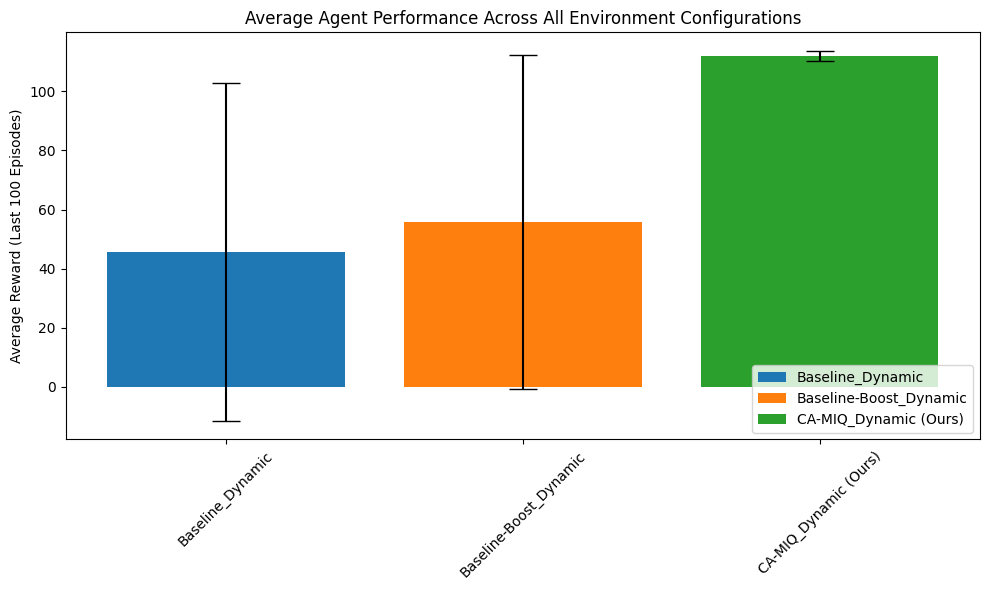

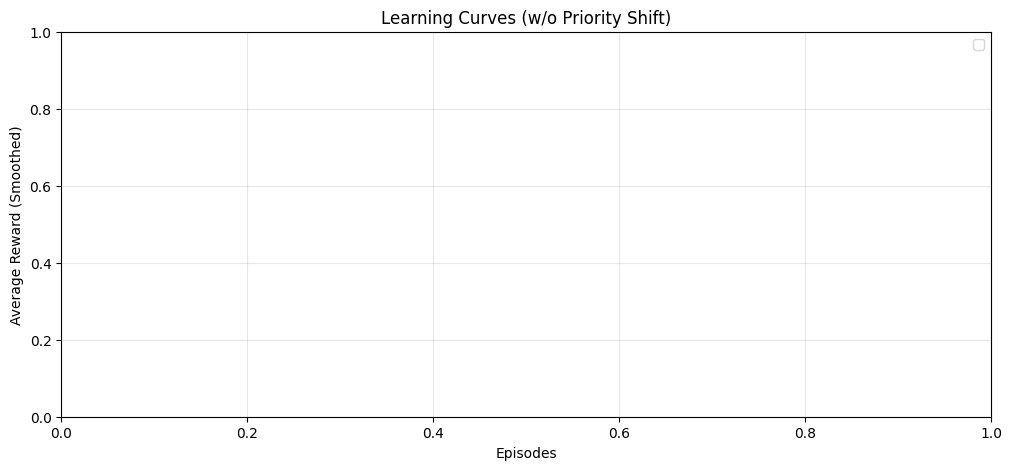

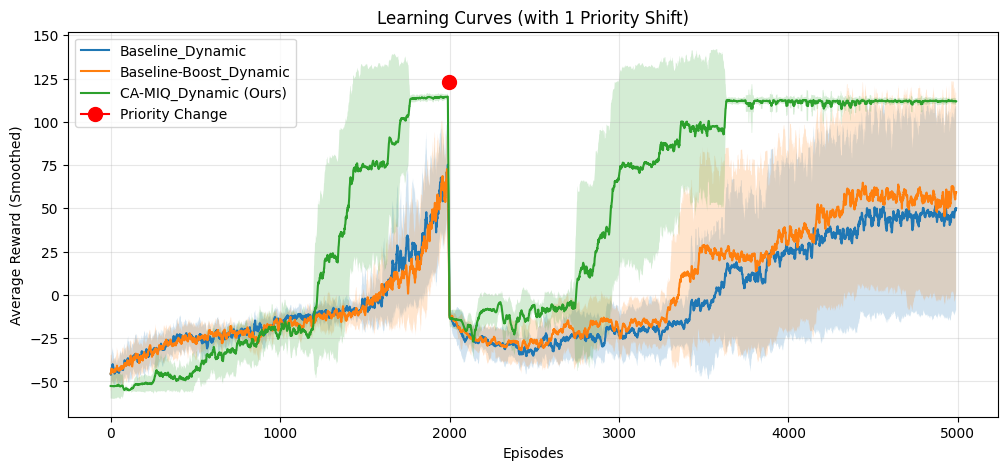

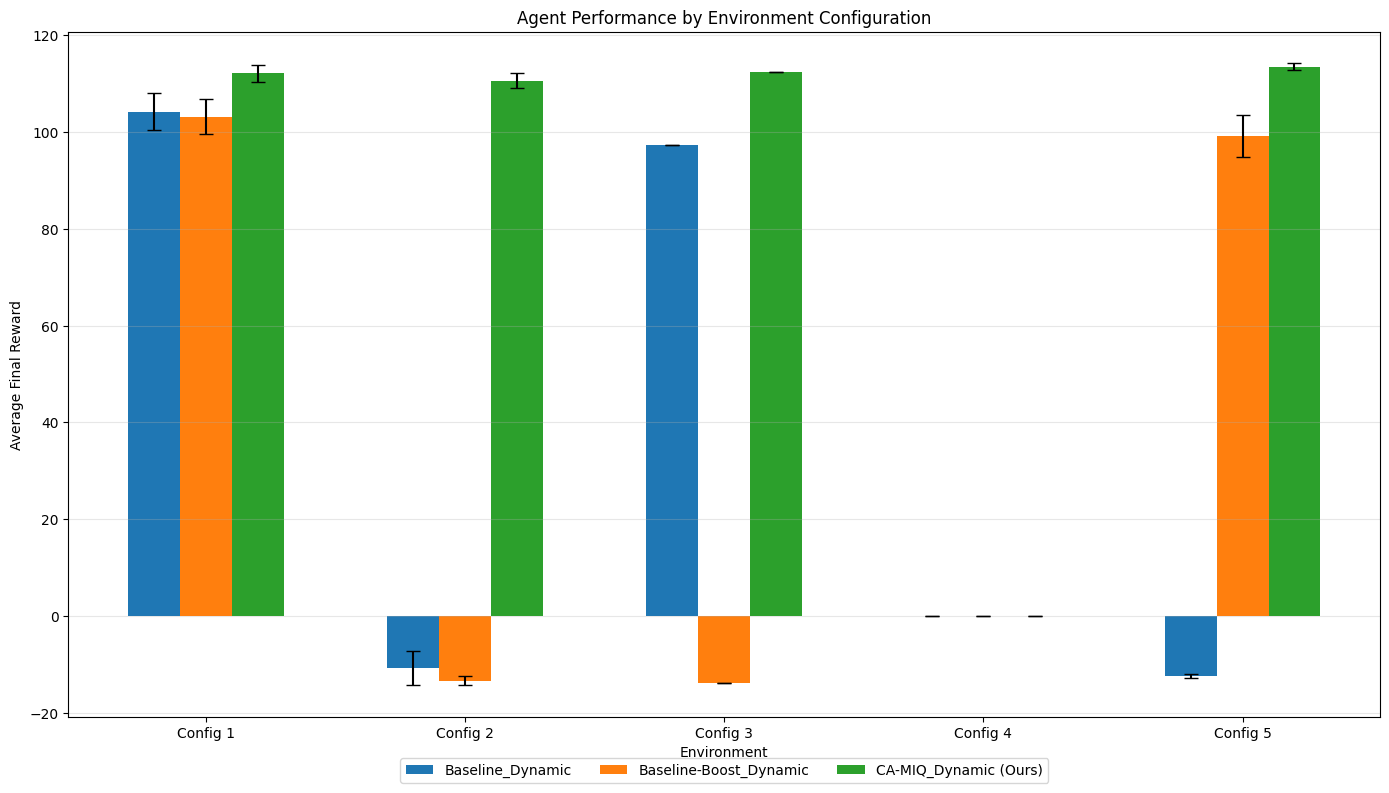

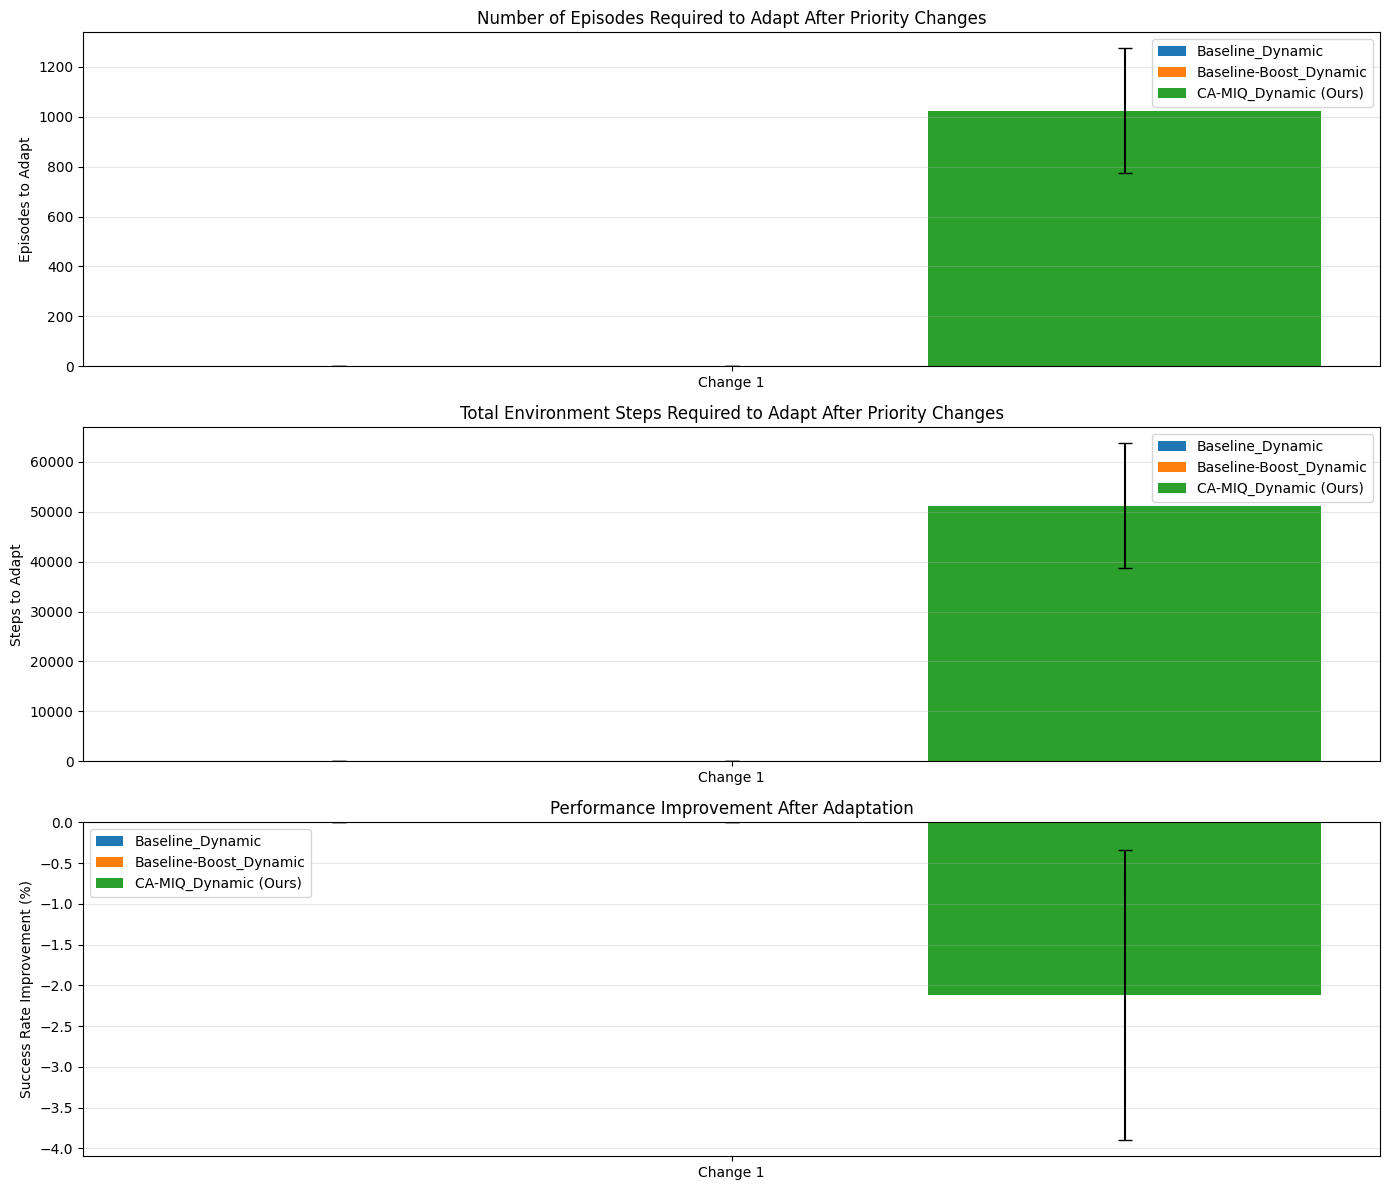

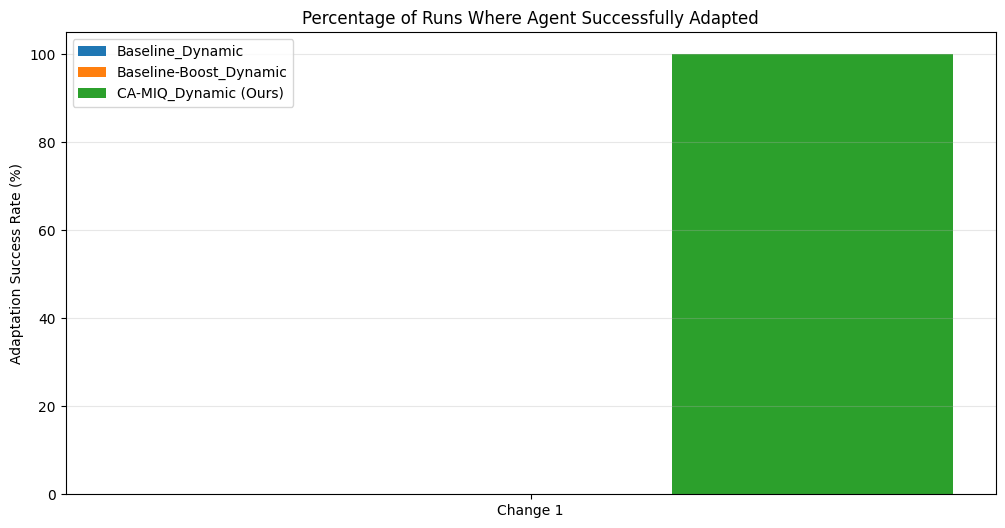

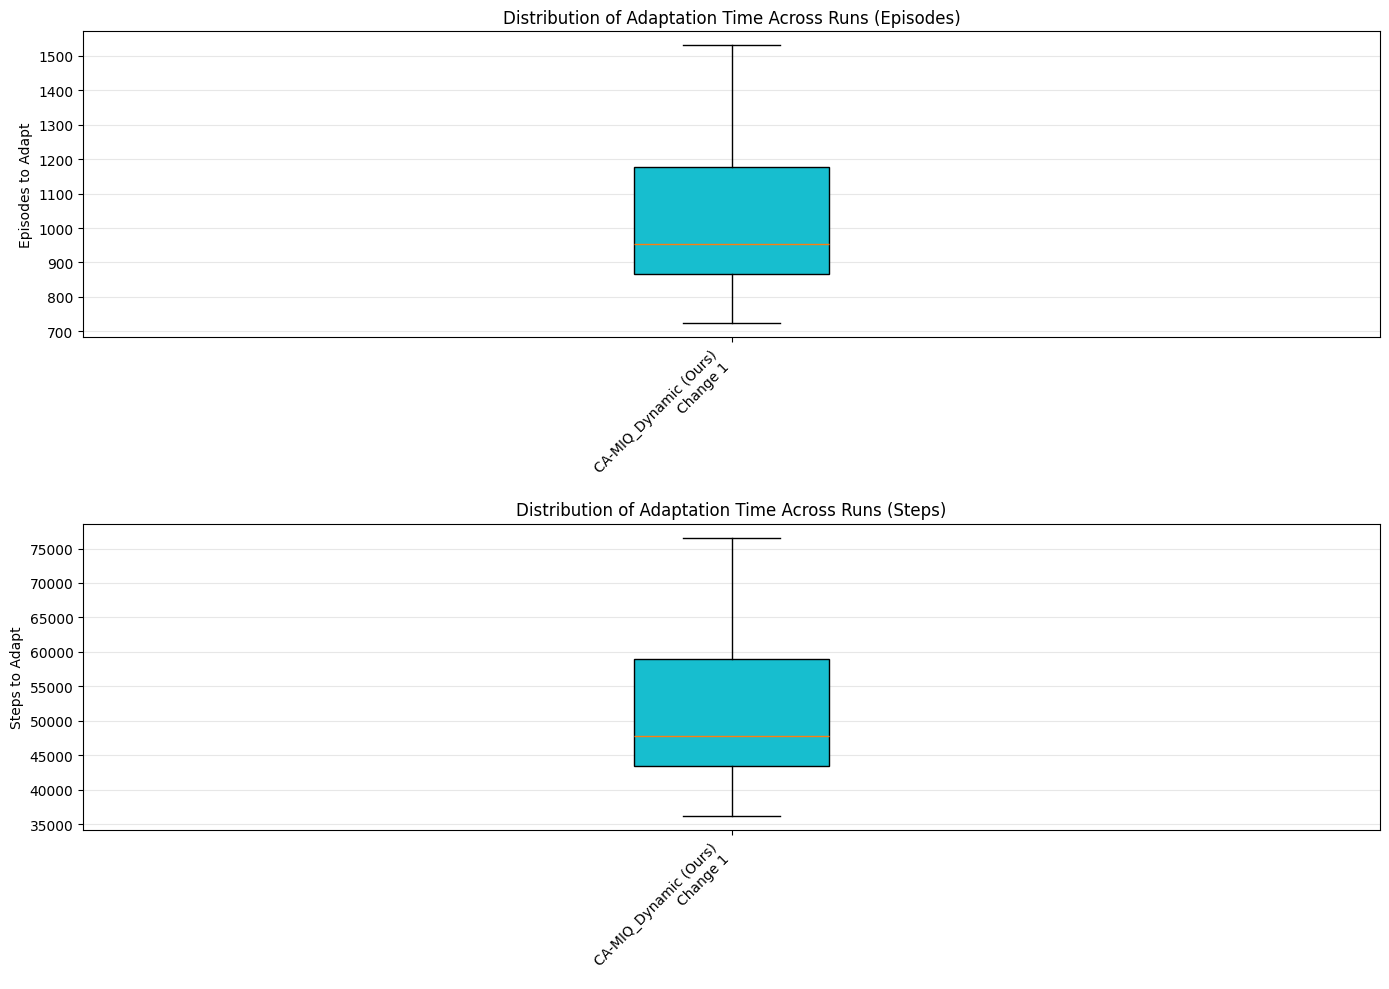

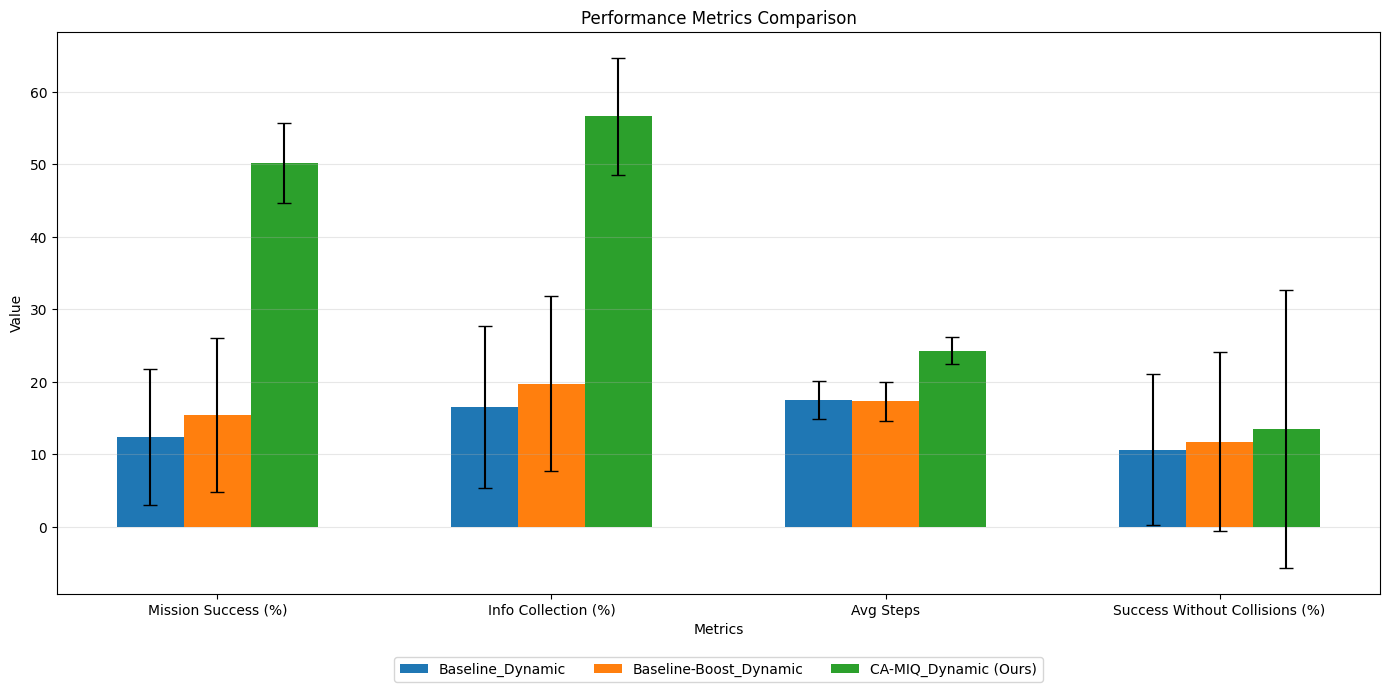

In [3]:
def generate_summary_visualizations(all_results, agent_types, env_configs, log_dir):
    """Generate comprehensive visualizations summarizing the experiment results."""
    # Create visualization directory
    vis_dir = os.path.join(log_dir, "visualizations")
    os.makedirs(vis_dir, exist_ok=True)
    
    # Organize data by agent type
    agent_data = {agent["name"]: {"rewards": [], "steps": [], "metrics": []} for agent in agent_types}
    
    # Group results by environment config
    env_results = {i: {"agent_performance": {}} for i in range(len(env_configs))}
    
    # Extract data from all trials
    for trial, data in all_results.items():
        config_idx = data["config_idx"]
        
        for agent_name, agent_result in data["results"].items():
            # Store raw rewards and steps data
            agent_data[agent_name]["rewards"].append(agent_result["rewards"])
            agent_data[agent_name]["steps"].append(agent_result["steps"])
            
            # Store metrics
            if "metrics" in agent_result:
                agent_data[agent_name]["metrics"].append(agent_result["metrics"])
            
            # Store performance by environment
            if agent_name not in env_results[config_idx]["agent_performance"]:
                env_results[config_idx]["agent_performance"][agent_name] = []
            
            # Use last 100 episodes as final performance measure
            last_100_rewards = agent_result["rewards"][-100:]
            env_results[config_idx]["agent_performance"][agent_name].append(np.mean(last_100_rewards))
    
    # 1. Overall Agent Performance Summary (average across all environments)
    print("\nAgent Performance Summary (across all environments):")
    for agent_name, data in agent_data.items():
        # Calculate average of last 100 episodes for each trial
        final_performances = []
        for reward_history in data["rewards"]:
            final_performances.append(np.mean(reward_history[-100:]))
        
        avg_performance = np.mean(final_performances)
        std_performance = np.std(final_performances)
        print(f"Agent {agent_name}: {avg_performance:.2f} ± {std_performance:.2f}")
    
    # 2. Create comparison chart for overall performance
    plt.figure(figsize=(10, 6))
    
    # Plot bars for each agent
    agent_names = list(agent_data.keys())
    x_pos = np.arange(len(agent_names))
    
    for i, agent_name in enumerate(agent_names):
        # Calculate average of last 100 episodes for each trial
        final_performances = []
        for reward_history in agent_data[agent_name]["rewards"]:
            final_performances.append(np.mean(reward_history[-100:]))
        
        plt.bar(x_pos[i], np.mean(final_performances), 
                yerr=np.std(final_performances), 
                capsize=10, 
                label=agent_name)
    
    plt.title("Average Agent Performance Across All Environment Configurations")
    plt.ylabel("Average Reward (Last 100 Episodes)")
    plt.xticks(x_pos, agent_names, rotation=45)
    plt.tight_layout()
    plt.legend()
    plt.savefig(os.path.join(vis_dir, "overall_agent_comparison.png"))
    
    # 3. Static vs Dynamic Agent Comparison
    window_size = 10  # For smoothing
    
    # 3.1 Static environment agents
    plt.figure(figsize=(12, 5))
    
    for agent_name, data in agent_data.items():
        if "Static" in agent_name:  # Only include static agents
            # Average rewards across all trials
            avg_rewards = np.mean(data["rewards"], axis=0)
            
            # Smooth rewards using moving average
            smoothed_rewards = np.convolve(avg_rewards, np.ones(window_size)/window_size, mode='valid')
            plt.plot(smoothed_rewards, label=agent_name)
            
            # Calculate confidence intervals
            all_smoothed = []
            for reward_history in data["rewards"]:
                run_smoothed = np.convolve(reward_history, np.ones(window_size)/window_size, mode='valid')
                all_smoothed.append(run_smoothed)
            
            all_smoothed = np.array(all_smoothed)
            std_dev = np.std(all_smoothed, axis=0)
            
            # Plot confidence interval (±1 std dev)
            x = np.arange(len(smoothed_rewards))
            plt.fill_between(x, smoothed_rewards - std_dev, smoothed_rewards + std_dev, alpha=0.2)
    
    plt.title('Learning Curves (w/o Priority Shift)')
    plt.xlabel('Episodes')
    plt.ylabel('Average Reward (Smoothed)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(os.path.join(vis_dir, 'reward_trends_static.png'))
    
    # 3.2 Dynamic environment agents
    plt.figure(figsize=(12, 5))
    dynamic_smoothed_rewards = {}  # Store for min/max calculation
    
    for agent_name, data in agent_data.items():
        if "Dynamic" in agent_name:  # Only include dynamic agents
            # Average rewards across all trials
            avg_rewards = np.mean(data["rewards"], axis=0)
            
            # Smooth rewards using moving average
            smoothed_rewards = np.convolve(avg_rewards, np.ones(window_size)/window_size, mode='valid')
            plt.plot(smoothed_rewards, label=agent_name)
            dynamic_smoothed_rewards[agent_name] = smoothed_rewards
            
            # Calculate confidence intervals
            all_smoothed = []
            for reward_history in data["rewards"]:
                run_smoothed = np.convolve(reward_history, np.ones(window_size)/window_size, mode='valid')
                all_smoothed.append(run_smoothed)
            
            all_smoothed = np.array(all_smoothed)
            std_dev = np.std(all_smoothed, axis=0)
            
            # Plot confidence interval (±1 std dev)
            x = np.arange(len(smoothed_rewards))
            plt.fill_between(x, smoothed_rewards - std_dev, smoothed_rewards + std_dev, alpha=0.2)
    
    # Add priority change markers (if we have data for dynamic agents)
    if dynamic_smoothed_rewards:
        # Calculate global min/max for consistent text placement
        all_rewards = np.concatenate(list(dynamic_smoothed_rewards.values()))
        min_reward = np.min(all_rewards)
        max_reward = np.max(all_rewards)
        
        # Get the change priority episodes from one of the dynamic agents
        for agent in agent_types:
            if agent["change_priorities"] is not None:
                for episode in agent["change_priorities"].keys():
                    if episode >= window_size//2:
                        adjusted_episode = episode - window_size//2
                        
                        bullet_y = max_reward + (max_reward - min_reward) * 0.05  # Slightly above highest reward
                        plt.plot(adjusted_episode, 
                                bullet_y, 
                                marker='o', 
                                markersize=10, 
                                color='red', 
                                label='Priority Change' if episode == list(agent["change_priorities"].keys())[0] else "")
                break  # Only need one agent's change points as they're the same
    
    plt.title('Learning Curves (with 1 Priority Shift)')
    plt.xlabel('Episodes')
    plt.ylabel('Average Reward (Smoothed)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(os.path.join(vis_dir, 'reward_trends_dynamic.png'))
    
    # 4. Performance by Environment Configuration
    plt.figure(figsize=(14, 8))
    
    # Setup
    env_labels = [f"Config {i+1}" for i in range(len(env_configs))]
    agent_names = list(agent_data.keys())
    x = np.arange(len(env_labels))
    width = 0.2  # width of the bars
    
    # Plot bars for each agent grouped by environment
    for i, agent_name in enumerate(agent_names):
        # Collect performance across environments
        env_perf = []
        env_std = []
        
        for env_idx in range(len(env_configs)):
            if agent_name in env_results[env_idx]["agent_performance"]:
                perf_values = env_results[env_idx]["agent_performance"][agent_name]
                if perf_values:
                    env_perf.append(np.mean(perf_values))
                    env_std.append(np.std(perf_values))
                else:
                    env_perf.append(0)
                    env_std.append(0)
            else:
                env_perf.append(0)
                env_std.append(0)
        
        # Calculate the offset for this agent's bars
        offset = width * (i - len(agent_names)/2 + 0.5)
        
        # Plot with error bars
        plt.bar(x + offset, env_perf, width, label=agent_name, yerr=env_std, capsize=5)
    
    plt.title('Agent Performance by Environment Configuration')
    plt.xlabel('Environment')
    plt.ylabel('Average Final Reward')
    plt.xticks(x, env_labels)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=len(agent_names))
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.savefig(os.path.join(vis_dir, 'performance_by_environment.png'))

    
    # Replace section 5 in generate_summary_visualizations with this enhanced adaptation metrics analysis

    # 5. Enhanced Adaptation Metrics Analysis
    # Collect adaptation metrics if available
    adaptation_metrics = {agent_name: [] for agent_name in agent_names if "Dynamic" in agent_name}

    print("\nProcessing adaptation metrics for analysis...")
    for agent_name in adaptation_metrics.keys():
        for metrics_list in agent_data[agent_name]["metrics"]:
            # Check both possible fields where the priority changes might be stored
            if "priority_changes" in metrics_list:
                adaptation_metrics[agent_name].append(metrics_list["priority_changes"])
            elif "all_priority_changes" in metrics_list:
                # Alternative field from our updated agent
                processed_changes = []
                for change in metrics_list["all_priority_changes"]:
                    # Convert raw change data to the expected format
                    processed_change = {
                        'episode': change.get('episode', 0),
                        'completed': change.get('adaptation_completed', False),
                        'success_rate_before': change.get('success_rate_before', 0),
                    }
                    
                    if change.get('adaptation_completed', False):
                        processed_change.update({
                            'steps_to_adapt': change.get('steps_to_adapt', 0),
                            'episodes_to_adapt': change.get('episodes_to_adapt', 0),
                            'success_rate_after': change.get('success_rate_after', 0)
                        })
                    else:
                        # For incomplete adaptations
                        processed_change.update({
                            'steps_without_recovery': change.get('steps_without_recovery', 0),
                            'episodes_without_recovery': change.get('episodes_without_recovery', 0)
                        })
                    
                    processed_changes.append(processed_change)
                
                adaptation_metrics[agent_name].append(processed_changes)

    # If we have adaptation metrics, create enhanced visualizations
    if any(metrics for metrics in adaptation_metrics.values()):
        print(f"Found adaptation metrics, creating visualizations...")
        
        # Find max number of changes
        max_changes = 0
        for metrics_list in adaptation_metrics.values():
            for run_metrics in metrics_list:
                max_changes = max(max_changes, len(run_metrics))
        
        if max_changes > 0:
            print(f"Found {max_changes} priority changes to analyze")
            
            # Setup
            labels = [f"Change {i+1}" for i in range(max_changes)]
            x = np.arange(len(labels))
            width = 0.35 / len(adaptation_metrics)
            
            # 5.1 Episodes to Adapt Analysis
            plt.figure(figsize=(14, 12))
            plt.subplot(3, 1, 1)
            
            # Plot episodes to adapt for each agent
            for i, (agent_name, metrics_list) in enumerate(adaptation_metrics.items()):
                # Calculate average episodes to adapt for each change
                avg_episodes = []
                std_episodes = []
                
                for change_idx in range(max_changes):
                    episode_values = []
                    
                    for run_metrics in metrics_list:
                        if change_idx < len(run_metrics):
                            change = run_metrics[change_idx]
                            if change.get('completed', False) and 'episodes_to_adapt' in change:
                                episode_values.append(change['episodes_to_adapt'])
                    
                    if episode_values:
                        avg_episodes.append(np.mean(episode_values))
                        std_episodes.append(np.std(episode_values))
                    else:
                        avg_episodes.append(0)
                        std_episodes.append(0)
                
                # Plot with offset for each agent
                offset = width * (i - len(adaptation_metrics)/2 + 0.5)
                plt.bar(x + offset, avg_episodes, width, label=agent_name, yerr=std_episodes, capsize=5)
            
            plt.ylabel('Episodes to Adapt')
            plt.title('Number of Episodes Required to Adapt After Priority Changes')
            plt.xticks(x, labels)
            plt.legend()
            plt.grid(True, alpha=0.3, axis='y')
            
            # 5.2 Steps to Adapt Analysis (original plot)
            plt.subplot(3, 1, 2)
            
            # Plot steps to adapt for each agent
            for i, (agent_name, metrics_list) in enumerate(adaptation_metrics.items()):
                # Calculate average steps to adapt for each change
                avg_steps = []
                std_steps = []
                
                for change_idx in range(max_changes):
                    steps_values = []
                    
                    for run_metrics in metrics_list:
                        if change_idx < len(run_metrics):
                            change = run_metrics[change_idx]
                            if change.get('completed', False) and 'steps_to_adapt' in change:
                                steps_values.append(change['steps_to_adapt'])
                    
                    if steps_values:
                        avg_steps.append(np.mean(steps_values))
                        std_steps.append(np.std(steps_values))
                    else:
                        avg_steps.append(0)
                        std_steps.append(0)
                
                # Plot with offset for each agent
                offset = width * (i - len(adaptation_metrics)/2 + 0.5)
                plt.bar(x + offset, avg_steps, width, label=agent_name, yerr=std_steps, capsize=5)
            
            plt.ylabel('Steps to Adapt')
            plt.title('Total Environment Steps Required to Adapt After Priority Changes')
            plt.xticks(x, labels)
            plt.legend()
            plt.grid(True, alpha=0.3, axis='y')
            
            # 5.3 Success Rate Improvement
            plt.subplot(3, 1, 3)
            
            # Plot success rate improvement for each agent
            for i, (agent_name, metrics_list) in enumerate(adaptation_metrics.items()):
                # Calculate success rate improvement for each change
                avg_improvement = []
                std_improvement = []
                
                for change_idx in range(max_changes):
                    improvement_values = []
                    
                    for run_metrics in metrics_list:
                        if change_idx < len(run_metrics):
                            change = run_metrics[change_idx]
                            if change.get('completed', False) and 'success_rate_before' in change and 'success_rate_after' in change:
                                improvement = change['success_rate_after'] - change['success_rate_before']
                                improvement_values.append(improvement)
                    
                    if improvement_values:
                        avg_improvement.append(np.mean(improvement_values))
                        std_improvement.append(np.std(improvement_values))
                    else:
                        avg_improvement.append(0)
                        std_improvement.append(0)
                
                # Plot with offset for each agent
                offset = width * (i - len(adaptation_metrics)/2 + 0.5)
                plt.bar(x + offset, avg_improvement, width, label=agent_name, yerr=std_improvement, capsize=5)
            
            plt.ylabel('Success Rate Improvement (%)')
            plt.title('Performance Improvement After Adaptation')
            plt.xticks(x, labels)
            plt.legend()
            plt.grid(True, alpha=0.3, axis='y')
            
            plt.tight_layout()
            plt.savefig(os.path.join(vis_dir, 'adaptation_metrics.png'))
            
            # 5.4 Adaptation Success Rate Analysis
            plt.figure(figsize=(12, 6))
            
            # Create a matrix of adaptation success rates for each agent and change
            for i, (agent_name, metrics_list) in enumerate(adaptation_metrics.items()):
                # Calculate success rate for each change
                success_rates = []
                
                for change_idx in range(max_changes):
                    total_runs = 0
                    success_count = 0
                    
                    for run_metrics in metrics_list:
                        if change_idx < len(run_metrics):
                            total_runs += 1
                            change = run_metrics[change_idx]
                            if change.get('completed', False):
                                success_count += 1
                    
                    if total_runs > 0:
                        success_rates.append((success_count / total_runs) * 100)
                    else:
                        success_rates.append(0)
                
                # Plot with offset for each agent
                offset = width * (i - len(adaptation_metrics)/2 + 0.5)
                plt.bar(x + offset, success_rates, width, label=agent_name)
            
            plt.ylabel('Adaptation Success Rate (%)')
            plt.title('Percentage of Runs Where Agent Successfully Adapted')
            plt.xticks(x, labels)
            plt.legend()
            plt.grid(True, alpha=0.3, axis='y')
            plt.savefig(os.path.join(vis_dir, 'adaptation_success_rates.png'))
            
            # 5.5 Adaptation Time Comparison
            plt.figure(figsize=(14, 10))
            
            # First subplot: Recovery time in episodes
            plt.subplot(2, 1, 1)
            
            # For each agent, create a box plot of episodes to adapt for each change
            boxplot_data = []
            agent_colors = plt.cm.tab10(np.linspace(0, 1, len(adaptation_metrics)))
            
            for agent_idx, (agent_name, metrics_list) in enumerate(adaptation_metrics.items()):
                for change_idx in range(max_changes):
                    episode_values = []
                    
                    for run_metrics in metrics_list:
                        if change_idx < len(run_metrics):
                            change = run_metrics[change_idx]
                            if change.get('completed', False) and 'episodes_to_adapt' in change:
                                episode_values.append(change['episodes_to_adapt'])
                    
                    if episode_values:
                        boxplot_data.append({
                            'label': f"{agent_name}\nChange {change_idx+1}",
                            'data': episode_values,
                            'color': agent_colors[agent_idx]
                        })
            
            if boxplot_data:
                # Create box plots
                boxes = plt.boxplot([item['data'] for item in boxplot_data], 
                                labels=[item['label'] for item in boxplot_data],
                                patch_artist=True,
                                showfliers=False)  # Hide outliers for clarity
                
                # Color boxes by agent
                for box, item in zip(boxes['boxes'], boxplot_data):
                    box.set(facecolor=item['color'])
            
            plt.ylabel('Episodes to Adapt')
            plt.title('Distribution of Adaptation Time Across Runs (Episodes)')
            plt.grid(True, alpha=0.3, axis='y')
            plt.xticks(rotation=45, ha='right')
            
            # Second subplot: Recovery time in steps
            plt.subplot(2, 1, 2)
            
            # For each agent, create a box plot of steps to adapt for each change
            boxplot_data = []
            
            for agent_idx, (agent_name, metrics_list) in enumerate(adaptation_metrics.items()):
                for change_idx in range(max_changes):
                    step_values = []
                    
                    for run_metrics in metrics_list:
                        if change_idx < len(run_metrics):
                            change = run_metrics[change_idx]
                            if change.get('completed', False) and 'steps_to_adapt' in change:
                                step_values.append(change['steps_to_adapt'])
                    
                    if step_values:
                        boxplot_data.append({
                            'label': f"{agent_name}\nChange {change_idx+1}",
                            'data': step_values,
                            'color': agent_colors[agent_idx]
                        })
            
            if boxplot_data:
                # Create box plots
                boxes = plt.boxplot([item['data'] for item in boxplot_data], 
                                labels=[item['label'] for item in boxplot_data],
                                patch_artist=True,
                                showfliers=False)  # Hide outliers for clarity
                
                # Color boxes by agent
                for box, item in zip(boxes['boxes'], boxplot_data):
                    box.set(facecolor=item['color'])
            
            plt.ylabel('Steps to Adapt')
            plt.title('Distribution of Adaptation Time Across Runs (Steps)')
            plt.grid(True, alpha=0.3, axis='y')
            plt.xticks(rotation=45, ha='right')
            
            plt.tight_layout()
            plt.savefig(os.path.join(vis_dir, 'adaptation_time_distributions.png'))
            
            # 5.6 Print Detailed Adaptation Summary Table
            print("\n" + "="*100)
            print("ADAPTATION METRICS SUMMARY")
            print("="*100)
            
            header = f"{'Agent':<20} | {'Change':<10} | {'Success Rate':<15} | {'Avg Episodes':<15} | {'Avg Steps':<15} | {'Improvement':<15}"
            print(header)
            print("="*100)
            
            for agent_name, metrics_list in adaptation_metrics.items():
                for change_idx in range(max_changes):
                    # Calculate metrics for this change and agent
                    success_count = 0
                    total_runs = 0
                    episode_values = []
                    step_values = []
                    improvement_values = []
                    
                    for run_metrics in metrics_list:
                        if change_idx < len(run_metrics):
                            total_runs += 1
                            change = run_metrics[change_idx]
                            
                            if change.get('completed', False):
                                success_count += 1
                                
                                if 'episodes_to_adapt' in change:
                                    episode_values.append(change['episodes_to_adapt'])
                                
                                if 'steps_to_adapt' in change:
                                    step_values.append(change['steps_to_adapt'])
                                
                                if 'success_rate_before' in change and 'success_rate_after' in change:
                                    improvement = change['success_rate_after'] - change['success_rate_before']
                                    improvement_values.append(improvement)
                    
                    # Calculate statistics
                    if total_runs > 0:
                        success_rate = f"{(success_count / total_runs) * 100:.1f}%"
                    else:
                        success_rate = "N/A"
                    
                    avg_episodes = f"{np.mean(episode_values):.2f}" if episode_values else "N/A"
                    avg_steps = f"{np.mean(step_values):.2f}" if step_values else "N/A"
                    avg_improvement = f"{np.mean(improvement_values):.2f}%" if improvement_values else "N/A"
                    
                    # Print row
                    row = f"{agent_name:<20} | {f'Change {change_idx+1}':<10} | {success_rate:<15} | {avg_episodes:<15} | {avg_steps:<15} | {avg_improvement:<15}"
                    print(row)
            
            # 5.7 Overall Adaptation Effectiveness Summary
            print("\n" + "="*100)
            print("OVERALL ADAPTATION EFFECTIVENESS")
            print("="*100)
            
            for agent_name, metrics_list in adaptation_metrics.items():
                # Calculate overall metrics across all changes
                total_changes = 0
                successful_adaptations = 0
                total_episodes = []
                total_steps = []
                
                for run_metrics in metrics_list:
                    for change in run_metrics:
                        total_changes += 1
                        
                        if change.get('completed', False):
                            successful_adaptations += 1
                            
                            if 'episodes_to_adapt' in change:
                                total_episodes.append(change['episodes_to_adapt'])
                            
                            if 'steps_to_adapt' in change:
                                total_steps.append(change['steps_to_adapt'])
                
                # Calculate overall statistics
                if total_changes > 0:
                    overall_success_rate = (successful_adaptations / total_changes) * 100
                    print(f"\nAgent: {agent_name}")
                    print(f"  Total priority changes: {total_changes}")
                    print(f"  Successfully adapted: {successful_adaptations} ({overall_success_rate:.1f}%)")
                    
                    if successful_adaptations > 0:
                        avg_episodes = np.mean(total_episodes) if total_episodes else "N/A"
                        avg_steps = np.mean(total_steps) if total_steps else "N/A"
                        print(f"  Average episodes to adapt: {avg_episodes:.2f}")
                        print(f"  Average steps to adapt: {avg_steps:.2f}")
                        
                        # Calculate statistics by change type
                        if max_changes > 1:
                            print("\n  Breakdown by change:")
                            for change_idx in range(max_changes):
                                change_episodes = []
                                change_steps = []
                                change_success = 0
                                change_total = 0
                                
                                for run_metrics in metrics_list:
                                    if change_idx < len(run_metrics):
                                        change_total += 1
                                        change = run_metrics[change_idx]
                                        
                                        if change.get('completed', False):
                                            change_success += 1
                                            
                                            if 'episodes_to_adapt' in change:
                                                change_episodes.append(change['episodes_to_adapt'])
                                            
                                            if 'steps_to_adapt' in change:
                                                change_steps.append(change['steps_to_adapt'])
                                
                                if change_total > 0:
                                    change_success_rate = (change_success / change_total) * 100
                                    avg_change_episodes = np.mean(change_episodes) if change_episodes else "N/A"
                                    print(f"    Change {change_idx+1}: {change_success_rate:.1f}% success rate, {avg_change_episodes:.2f} avg episodes")
    
    # 6. Performance metrics comparison
    # Define key metrics to compare
    metrics_to_compare = [
        'mission_success_rate', 
        'info_collection_success_rate',
        'average_steps_per_episode',
        'mission_success_no_collisions_rate'
    ]
    
    metric_labels = {
        'mission_success_rate': 'Mission Success (%)',
        'info_collection_success_rate': 'Info Collection (%)',
        'average_steps_per_episode': 'Avg Steps',
        'mission_success_no_collisions_rate': 'Success Without Collisions (%)'
    }
    
    # Check if we have these metrics
    have_metrics = True
    for agent_name, data in agent_data.items():
        if not data["metrics"] or not all(metric in data["metrics"][0] for metric in metrics_to_compare):
            have_metrics = False
            break
    
    if have_metrics:
        plt.figure(figsize=(14, 7))
        
        # Setup
        x = np.arange(len(metrics_to_compare))
        width = 0.2  # width of the bars
        
        # Calculate average metrics for each agent
        for i, agent_name in enumerate(agent_names):
            # Collect all values for each metric
            metric_values = []
            metric_stds = []
            
            for metric in metrics_to_compare:
                values = [m.get(metric, 0) for m in agent_data[agent_name]["metrics"]]
                metric_values.append(np.mean(values))
                metric_stds.append(np.std(values))
            
            # Calculate the offset for this agent's bars
            offset = width * (i - len(agent_names)/2 + 0.5)
            
            # Plot with error bars
            plt.bar(x + offset, metric_values, width, label=agent_name, yerr=metric_stds, capsize=5)
        
        plt.xlabel('Metrics')
        plt.ylabel('Value')
        plt.title('Performance Metrics Comparison')
        plt.xticks(x, [metric_labels[metric] for metric in metrics_to_compare])
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=len(agent_names))
        plt.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.savefig(os.path.join(vis_dir, 'performance_metrics.png'))
        
        # Print summary table
        print("\n" + "="*100)
        print("PERFORMANCE COMPARISON SUMMARY (AVERAGED ACROSS ALL ENVIRONMENTS)")
        print("="*100)
        
        header = f"{'Metric':<40} | " + " | ".join([f"{name:<15}" for name in agent_names])
        print(header)
        print("="*100)
        
        metrics_to_print = metrics_to_compare + ['average_reward_per_episode']
        
        for metric in metrics_to_print:
            values = []
            for agent_name in agent_names:
                # Calculate average value across all trials
                metric_values = [m.get(metric, 0) for m in agent_data[agent_name]["metrics"] if metric in m]
                if metric_values:
                    avg_value = np.mean(metric_values)
                    values.append(f"{avg_value:.2f}")
                else:
                    values.append("N/A")
            
            metric_name = metric_labels.get(metric, metric)
            row = f"{metric_name:<40} | " + " | ".join([f"{val:<15}" for val in values])
            print(row)
    
    print(f"\nResults and visualizations saved to {log_dir}")
    return vis_dir
generate_summary_visualizations(results, agent_types, env_configs, log_dir)


In [ ]:
from evaluation import evaluate_trained_policy
evaluate_trained_policy(agent, "logs/comparison_20250428_173812/policies/MaxInfoRL_Dynamic/q_extrinsic_table_episode_5000.npy")
# evaluate_trained_policy(agent_maxinfo, "policies/ADV/q_extrinsic_table_episode_5000.npy")

In [ ]:
### FOR TESTING ### newwww

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pickle
from environment_sar import SARrobotEnv
from agents import QLearningAgentFlat, QLearningAgentMaxInfoRL
from evaluation import plot_accumulated_rewards, load_training_results, save_training_results
from robot_utils import RunningParameters
param = RunningParameters()

In [ ]:
# Define experiments
experiments = [
    {
        "change_priorities": {
            1700: {'X': 2, 'Y': 0, 'Z': 1},  # Change from X-Y-Z to Y-Z-X
            3500: {'X': 0, 'Y': 2, 'Z': 1},  # Change to Z-X-Y
        }
    }
]

agent_config = {
    # List of agent variable names as strings
    'agent_vars': [
        'all_total_rewards_AGENT_flat',
        'all_total_rewards_AGENT_flatB',
        'all_total_rewards_AGENTmaxinfo'     
        
    ],
    # Corresponding labels and colors for each agent
    'labels': [
        'Q-learning-Flat', 
        'Q-learning-Boost',
        'Q-learning-Dual'
    ],
    'colors': [
        'blue',
        'orange',  
        'green'
    ]
}

In [ ]:
## 1) Q-learning-flat -- TESTING

all_total_rewards_AGENT_flat = []  # List to store total rewards from each run
all_total_steps_AGENT_flat = []  # List to store total rewards from each run
all_metrics_AGENT_flat = [] # New list to store metrics from each run
for exp in experiments:  # Loop through experiments
    for _ in range(param.testing_runs):
        env = SARrobotEnv(
            grid_rows=4,
            grid_cols=4,
            info_number_needed=3,
            sparse_reward=False,
            reward_shaping=False,
            attention=False,
            hierarchical=False,
            render_mode='None'
        )
        
        EPISODES = param.EPISODES
        ALPHA = param.ALPHA
        GAMMA = param.GAMMA
        EPSILON_MAX = param.EPSILON_MAX
        EPSILON_MIN = param.EPSILON_MIN
        DECAY_RATE = param.DECAY_RATE
        agent_flat = QLearningAgentFlat(env, ALPHA, GAMMA, EPSILON_MAX, DECAY_RATE, EPSILON_MIN,
                                        log_rewards_dir="curves/flat", learned_policy_dir="policies/flat")
        rewards_flat, steps_flat, metrics_flat = agent_flat.train(5000, change_priorities_at=exp["change_priorities"], boost=False)

        all_total_rewards_AGENT_flat.append(rewards_flat)
        all_total_steps_AGENT_flat.append(steps_flat)
        all_metrics_AGENT_flat.append(metrics_flat)  # Store the metrics

    save_training_results(agent_config['labels'][0], all_total_rewards_AGENT_flat, all_total_steps_AGENT_flat, all_metrics_AGENT_flat, save_dir='saved_results_no_sparse')
# time.sleep(param.sleeping_time)

In [ ]:
## 1) Q-learning-flat -- TESTING -- with BOOST
all_total_rewards_AGENT_flatB = []  # List to store total rewards from each run
all_total_steps_AGENT_flatB = []  # List to store total rewards from each run
all_metrics_AGENT_flatB = [] # New list to store metrics from each run
for exp in experiments:  # Loop through experiments
    for _ in range(param.testing_runs):
        env = SARrobotEnv(
            grid_rows=4,
            grid_cols=4,
            info_number_needed=3,
            sparse_reward=False,
            reward_shaping=False,
            attention=False,
            hierarchical=False,
            render_mode='None'
        )
        
        EPISODES = param.EPISODES
        ALPHA = param.ALPHA
        GAMMA = param.GAMMA
        EPSILON_MAX = param.EPSILON_MAX
        EPSILON_MIN = param.EPSILON_MIN
        DECAY_RATE = param.DECAY_RATE
        agent_flatB = QLearningAgentFlat(env, ALPHA, GAMMA, EPSILON_MAX, DECAY_RATE, EPSILON_MIN,
                                        log_rewards_dir="curves/flatB", learned_policy_dir="policies/flatB")
        rewards_flatB, steps_flatB, metrics_flatB = agent_flatB.train(5000, change_priorities_at=exp["change_priorities"], boost=True)

        all_total_rewards_AGENT_flatB.append(rewards_flatB)
        all_total_steps_AGENT_flatB.append(steps_flatB)
        all_metrics_AGENT_flatB.append(metrics_flatB)  # Store the metrics
    save_training_results(agent_config['labels'][1], all_total_rewards_AGENT_flatB, all_total_steps_AGENT_flatB, all_metrics_AGENT_flatB, save_dir='saved_results_no_sparse')


In [ ]:
all_total_rewards_AGENTmaxinfo = []  # List to store total rewards from each run
all_total_steps_AGENTmaxinfo = []  # List to store total rewards from each run
all_metrics_AGENTmaxinfo = [] # New list to store metrics from each run
for exp in experiments:  # Loop through experiments
    for _ in range(param.testing_runs):
        env = SARrobotEnv(
            grid_rows=4,
            grid_cols=4,
            info_number_needed=3,
            sparse_reward=False,
            reward_shaping=False,
            attention=False,
            hierarchical=False,
            render_mode='None'
        )
        

        EPISODES = param.EPISODES
        ALPHA = param.ALPHA
        GAMMA = param.GAMMA
        EPSILON_MAX = param.EPSILON_MAX
        EPSILON_MIN = param.EPSILON_MIN
        DECAY_RATE = param.DECAY_RATE
        agent_maxinfo = QLearningAgentMaxInfoRL(env, ALPHA, GAMMA, EPSILON_MAX, DECAY_RATE, EPSILON_MIN,
                                        log_rewards_dir="curves/ADV", learned_policy_dir="policies/ADV")
        rewards_maxinfo, steps_maxinfo, metrics_maxinfo = agent_maxinfo.train(5000, change_priorities_at=exp["change_priorities"])

        all_total_rewards_AGENTmaxinfo.append(rewards_maxinfo)
        all_total_steps_AGENTmaxinfo.append(steps_maxinfo)
        all_metrics_AGENTmaxinfo.append(metrics_maxinfo)  # Store the metrics
    save_training_results(agent_config['labels'][2], all_total_rewards_AGENTmaxinfo, all_total_steps_AGENTmaxinfo, all_metrics_AGENTmaxinfo, save_dir='saved_results_no_sparse')

In [ ]:
# Create a dictionary to store loaded rewards
all_agent_rewards = {}

# Load rewards for each agent from saved files
for i, label in enumerate(agent_config['labels']):
    # Load rewards using the existing function
    loaded_data = load_training_results(
        base_name=label,
        data_type='rewards',  # Change from 'metrics' to 'rewards'
        file_format='pickle',
        save_dir='saved_results_no_sparse'
    )
    
    # Add to dictionary if rewards were successfully loaded
    if loaded_data is not None:
        all_agent_rewards[label] = loaded_data
    else:
        print(f"Warning: Could not load rewards for {label}")

# Call the plotting function with your data
fig, ax = plot_accumulated_rewards(
    reward_list=[all_agent_rewards[label] for label in agent_config['labels'] if label in all_agent_rewards],
    labels=[label for label in agent_config['labels'] if label in all_agent_rewards],
    colors=agent_config['colors'],
    window_size=500,
    figsize=(10, 6),
    save_path='agent_performance_comparison',
    use_savgol=False
)